1.1 Load the SOTRM Dataset as TCTracks Data Type

In [2]:
from climada.hazard import TCTracks, TropCyclone, Centroids

tracks_sync_1000yr = TCTracks.from_simulations_storm('clim_syn_tracks/STORM_DATA_HadGEM3-GC31-HM_NI_1000_YEARS_0_IBTRACSDELTA.txt')

In [3]:
tc_tracks = TCTracks.from_ibtracs_netcdf(basin='NI')

2025-05-15 17:03:25,604 - climada.hazard.tc_tracks - WARNING - 1458 storm events are discarded because no valid wind/pressure values have been found: 1842298N11080, 1845336N10074, 1854303N14072, 1877135N10083, 1877192N21090, ...
2025-05-15 17:03:25,614 - climada.hazard.tc_tracks - WARNING - 1 storm events are discarded because only one valid timestep has been found: 1995269N21088.


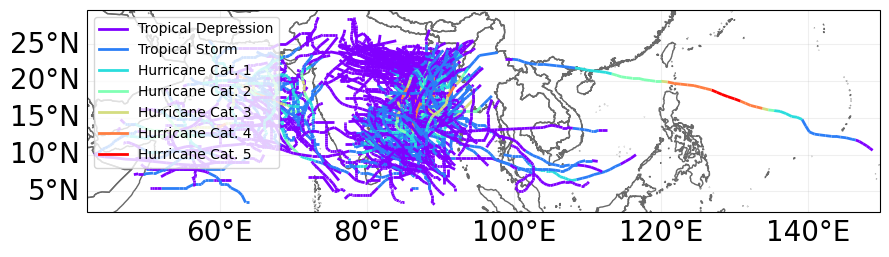

In [4]:
ax = tc_tracks.plot()
ax.get_legend()._loc = 2

1.2 Load Coal Plant Exposures

In [5]:
import pandas as pd
from climada.entity import Exposures

# Define exposrues here
file_name = 'exposures/exposures_coal.xlsx'
exposures = pd.read_excel(file_name)

exp  = Exposures(exposures, ref_year=2024)
print(exp)

description: None
ref_year: 2024
value_unit: USD
crs: EPSG:4326
data: (95 entries)
           value  impf_TC                         Plant name  \
0   1.603000e+09        1          Adani Godda power station   
1   1.890239e+09        1     Aditya Aluminium power station   
2   3.784000e+07        1     Amravati Thermal Power Project   
3   4.742700e+08        1                Angul power station   
91  8.483000e+07        1  Visakhapatnam Sarda power station   
92  8.920050e+08        1          Vizag Thermal Power Plant   
93  2.812695e+09        1              Yadadri power station   
94  2.600000e+08        1             Yermarus power station   

                     geometry  
0   POINT (87.13546 24.81411)  
1   POINT (84.06059 21.74007)  
2   POINT (77.90124 21.08032)  
3   POINT (84.98055 21.12704)  
91  POINT (82.96136 17.46644)  
92  POINT (83.13888 17.56364)  
93  POINT (79.58118 16.70822)  
94  POINT (77.35612 16.29526)  


In [6]:
# Define the centroids from the exposures position
lat = exposures["latitude"].values
lon = exposures["longitude"].values
centrs = Centroids.from_lat_lon(lat, lon)

C:\Users\beste\AppData\Local\Temp\ipykernel_7188\386028382.py:4: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)


1.3 Create the Windfields and Hazard Object

In [4]:
# Using the tracks, compute the windspeed at the location of the centroids
tc = TropCyclone.from_tracks(tracks_sync_1000yr, centroids=centrs, store_windfields=True)
cyclones = TropCyclone.from_tracks(tc_tracks, centroids=centrs, store_windfields=True)

# Compute the windspeed at the centroids
local_exceedance_impacts, title, column_label = cyclones.local_exceedance_intensity([5, 10, 25, 50, 100, 200, 500, 1000], method='extrapolate_constant')
local_exceedance_impacts, title, column_label

NameError: name 'centrs' is not defined

In [8]:
type(local_exceedance_impacts)

geopandas.geodataframe.GeoDataFrame

In [26]:
df = pd.DataFrame(local_exceedance_impacts.drop(columns=['geometry']))
type(df)

pandas.core.frame.DataFrame

In [27]:
print(df)
df.to_excel('exceedence_coal.xlsx', index=False)

      5         10         25         50   100   200   500  1000
0   0.0   0.000000  18.094862  19.338601  20.0  20.0  20.0  20.0
1   0.0  18.408304  21.132470  23.892997  26.0  26.0  26.0  26.0
2   0.0   0.000000   0.000000   0.000000  19.0  19.0  19.0  19.0
3   0.0  20.408943  25.385925  28.489724  29.0  29.0  29.0  29.0
4   0.0  21.490751  26.507826  30.000000  30.0  30.0  30.0  30.0
..  ...        ...        ...        ...   ...   ...   ...   ...
90  0.0  19.805491  25.848300  32.973067  34.0  34.0  34.0  34.0
91  0.0   0.000000  20.259336  28.820722  38.0  38.0  38.0  38.0
92  0.0   0.000000  20.940559  30.970482  42.0  42.0  42.0  42.0
93  0.0   0.000000   0.000000  18.487353  19.0  19.0  19.0  19.0
94  0.0   0.000000   0.000000   0.000000   0.0   0.0   0.0   0.0

[95 rows x 8 columns]


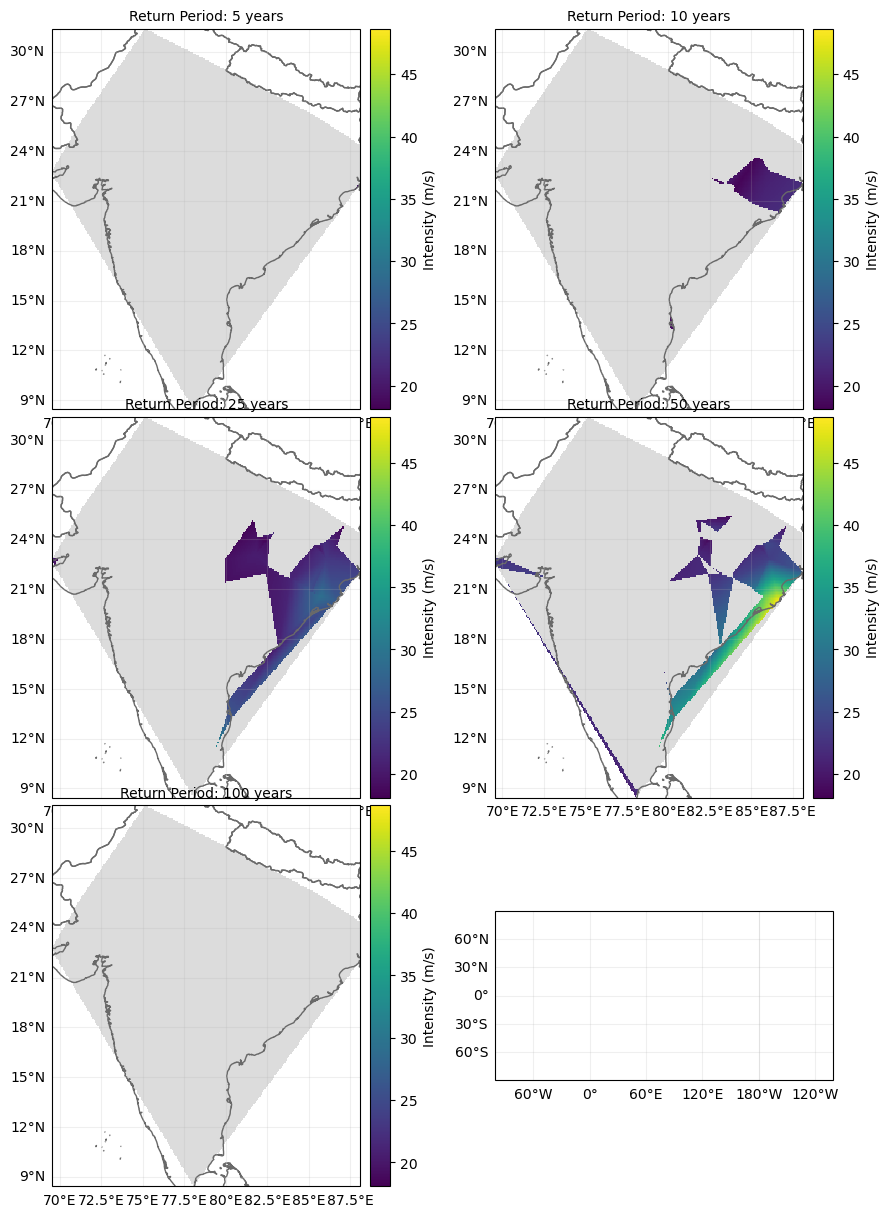

In [47]:
from climada.util.plot import plot_from_gdf

plot_from_gdf(local_exceedance_impacts, title, column_label, smooth=False);

In [10]:
tc.category

array([1, 3, 2, ..., 4, 2, 3])

In [11]:
tc.set_frequency(yearrange=(1980, 2024))
tc.frequency

array([0.02222222, 0.02222222, 0.02222222, ..., 0.02222222, 0.02222222,
       0.02222222])

1.4 Impact Function Selection and Impact Calculation

In [12]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])

In [13]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [24]:
exp.gdf.geometry

0     POINT (87.13546 24.81411)
1     POINT (84.06059 21.74007)
2     POINT (77.90124 21.08032)
3     POINT (84.98055 21.12704)
4     POINT (84.99039 20.89247)
                ...            
90    POINT (80.30175 13.23713)
91    POINT (82.96136 17.46644)
92    POINT (83.13888 17.56364)
93    POINT (79.58118 16.70822)
94    POINT (77.35612 16.29526)
Name: geometry, Length: 95, dtype: geometry

In [ ]:
# Compute impact
from climada.engine import ImpactCalc, Impact

imp = ImpactCalc(exp, impf_set, tc).impact(
    save_mat=True
) # Save the impact in a mat file

In [ ]:
print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

Aggregated average annual impact: 837091946.0 $


<GeoAxes: title={'center': 'Expected annual impact'}>

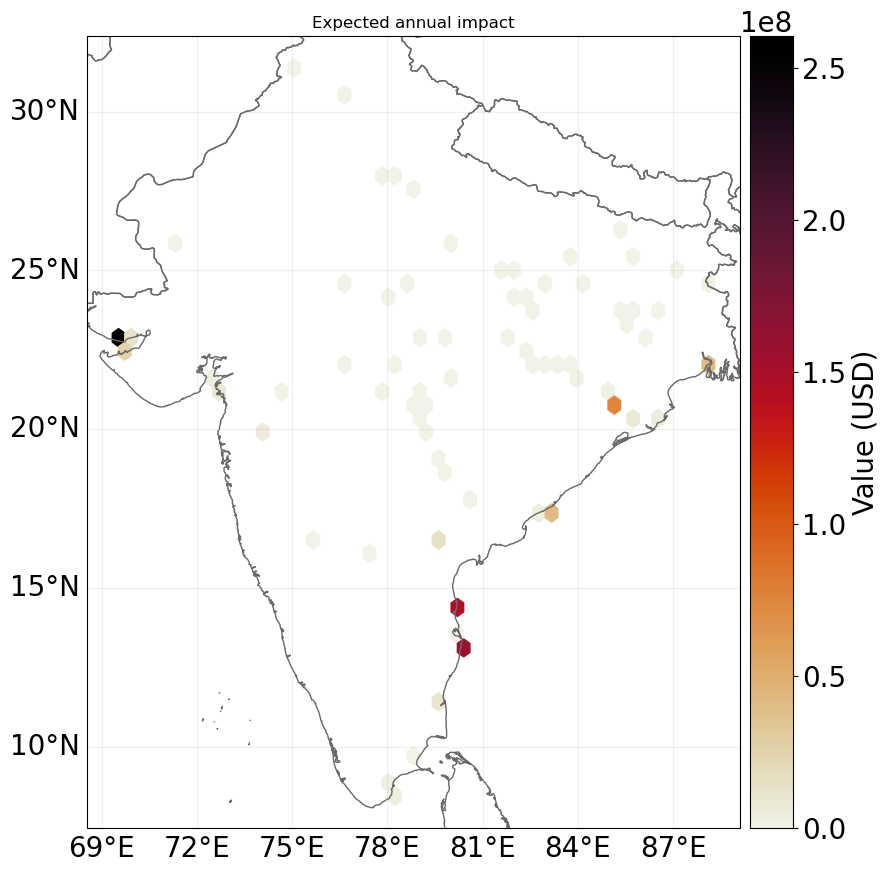

In [ ]:
imp.plot_hexbin_eai_exposure(buffer=1, pop_name=False)

In [ ]:
imp.impact_per_year()
imp.eai_exp

array([1.51180226e+04, 1.07200821e+06, 0.00000000e+00, 3.02197525e+06,
       6.00567530e+06, 0.00000000e+00, 2.47457407e+07, 6.70330799e+07,
       0.00000000e+00, 5.47534822e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.26099847e+07, 0.00000000e+00, 5.71713475e+03,
       1.68474023e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.35866536e+06, 3.44383847e+05, 0.00000000e+00,
       0.00000000e+00, 4.83169990e+07, 4.25422244e+07, 4.51257849e+06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.99879022e+02,
       2.06580974e+07, 0.00000000e+00, 7.22633527e+06, 2.11899115e+07,
       7.72932099e+05, 0.00000000e+00, 0.00000000e+00, 1.81965650e+05,
       1.43899205e+05, 1.62694969e+05, 2.32122387e+07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.67035003e+05, 0.00000000e+00,
       8.90653711e+04, 0.00000000e+00, 1.07283376e+04, 0.00000000e+00,
       0.00000000e+00, 3.91459934e+06, 0.00000000e+00, 7.91353554e+05,
      

In [30]:
pl = imp.calc_freq_curve()
print(imp.local_exceedance_impact(return_periods=[5, 10, 25, 50, 100]))

(                     geometry             5            10            25  50  \
0   POINT (87.13546 24.81411)           NaN           NaN           NaN NaN   
1   POINT (84.06059 21.74007)           NaN           NaN  6.698580e+06 NaN   
2   POINT (77.90124 21.08032)           NaN           NaN           NaN NaN   
3   POINT (84.98055 21.12704)  1.983426e+06  9.718862e+06  3.815033e+07 NaN   
4   POINT (84.99039 20.89247)  5.000000e+06  2.892715e+07  5.615086e+07 NaN   
..                        ...           ...           ...           ...  ..   
90  POINT (80.30175 13.23713)  1.700000e+07  4.603230e+07  2.143060e+08 NaN   
91  POINT (82.96136 17.46644)  6.900000e+06  1.273481e+07  2.470039e+07 NaN   
92  POINT (83.13888 17.56364)  6.800000e+07  1.029347e+08  2.243166e+08 NaN   
93  POINT (79.58118 16.70822)  1.900000e+07  5.477545e+07  1.164468e+08 NaN   
94  POINT (77.35612 16.29526)           NaN           NaN  8.894598e+04 NaN   

    100  
0   NaN  
1   NaN  
2   NaN  
3   NaN  


In [16]:
imp.at_event

array([2.14292057e+07, 0.00000000e+00, 3.13112458e+06, ...,
       1.12692742e+08, 0.00000000e+00, 0.00000000e+00])

In [17]:
years = [int(tr.attrs['id_no'] / 1000) for tr in tracks_sync_1000yr.data]
years = list(set(years))
years.sort()
print(years)

[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 62, 63, 64, 65, 67, 68, 69, 70, 71, 73, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 91, 93, 94, 97, 98, 99, 101, 102, 103, 104, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 180, 181, 183, 185, 186, 187, 189, 191, 192, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 217, 218, 220, 221, 222, 224, 225, 226, 227, 228, 229, 231, 233, 234, 235, 236, 237, 238, 239, 240, 241, 244, 245, 246, 247, 248, 249, 250, 253, 254, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 268, 2

In [14]:
def impact_visual(data):

    tc = TropCyclone.from_tracks(data, centroids=centrs)
    impf_tc = ImpfTropCyclone.from_emanuel_usa()
    # add the impact function to an Impact function set
    impf_set = ImpactFuncSet([impf_tc])
    [haz_type] = impf_set.get_hazard_types()
    [haz_id] = impf_set.get_ids()[haz_type]
    imp = ImpactCalc(exp, impf_set, tc).impact(
    save_mat=True)
    print(f"Aggregated average annual impact: {imp.aai_agg} $")

    return

Aggregated average annual impact: 432063857.6439129 $


<GeoAxes: >

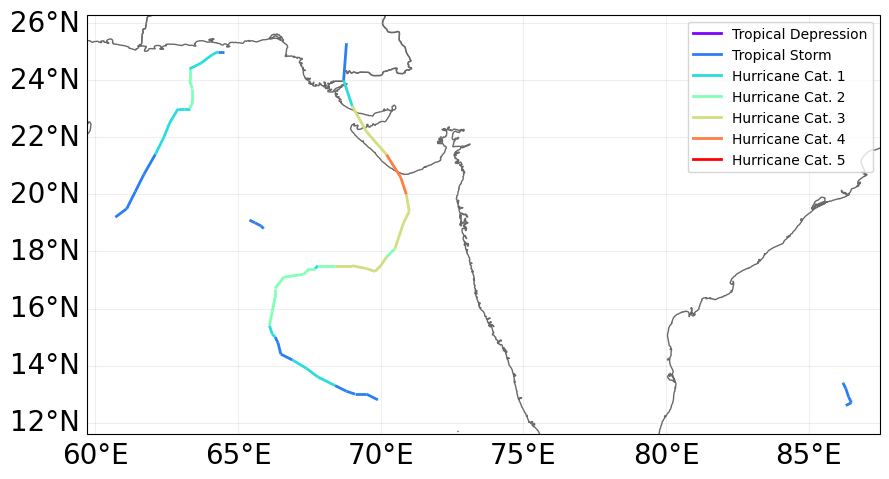

In [20]:
tracks_sync_yr = TCTracks.from_simulations_storm('syn_tracks/STORM_DATA_IBTRACS_NI_1000_YEARS_0.txt',years=1)
impact_visual(tracks_sync_yr)
tracks_sync_yr.plot()

1.5 Define Function for per Year Based Calculation

In [ ]:
from climada.hazard import TCTracks, TropCyclone

i = 1
while i < 100:
    if i == 20:
        i += 1
        continue
    print(i)
    tr = TCTracks.from_simulations_storm('syn_tracks/STORM_DATA_IBTRACS_NI_1000_YEARS_0.txt', years=i)
    impact_visual(tr)
    i += 1

In [21]:
import numpy as np
import matplotlib.pyplot as plt

1.6 Cumulative Damage Calculation Based on Total Years Passed

In [ ]:
def impact_calculator(return_period, exp, centrs):
    try:
        # Generate a list of years up to the return period
        years = list(range(return_period + 1))

        # Load tropical cyclone tracks
        data = TCTracks.from_simulations_storm('clim_syn_tracks/STORM_DATA_HadGEM3-GC31-HM_NI_1000_YEARS_0_IBTRACSDELTA.txt', years=years)

        # Create a TropCyclone object
        tc = TropCyclone.from_tracks(data, centroids=centrs)

        # Define impact function set
        impf_tc = ImpfTropCyclone.from_emanuel_usa(v_half=70.8)
        impf_set = ImpactFuncSet([impf_tc])

        # Calculate impact
        imp = ImpactCalc(exp, impf_set, tc).impact(save_mat=True)

        return rp_vals  # Return the expected annual impact

    except Exception as e:
        print(f"Error in return period {return_period}: {e}")
        return None

In [3]:
return_periods=[5,10,25,50,100,200,500,1000]

In [ ]:
# Calculate impacts
impact_results_coal = {
    rp: impact_calculator(rp, exp, centrs) for rp in return_periods
}

# Convert to DataFrame
damage_coal_df = pd.DataFrame(impact_results_coal)

# Show results
print(damage_coal_df)
damage_coal_df.to_excel('damage_coal.xlsx', index=False)

Now considering different energy types.

In [11]:
from climada.entity import Exposures
import pandas as pd

exposures_bio = pd.read_excel('exposures/exposure_bioenergy.xlsx')
exp_bio  = Exposures(pd.read_excel('exposures/exposure_bioenergy.xlsx'), ref_year=2024)

In [24]:
# Define the centroids from the exposures position
lat = exposures_bio["latitude"].values
lon = exposures_bio["longitude"].values
centrs = Centroids.from_lat_lon(lat, lon)

cyclones = TropCyclone.from_tracks(tc_tracks, centroids=centrs, store_windfields=True)

C:\Users\beste\AppData\Local\Temp\ipykernel_15828\879862913.py:4: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)


In [25]:
local_exceedance_impacts, title, column_label = cyclones.local_exceedance_intensity([5, 10, 25, 50, 100, 200, 500, 1000], method='extrapolate_constant')
local_exceedance_impacts, title, column_label

c:\Users\beste\miniforge3\envs\climada_env\Lib\site-packages\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)


(                     geometry    5         10         25         50   100  \
 0   POINT (76.56510 17.46220)  0.0   0.000000   0.000000   0.000000   0.0   
 1   POINT (78.54460 28.70600)  0.0   0.000000   0.000000   0.000000   0.0   
 2   POINT (77.70290 29.12170)  0.0   0.000000   0.000000   0.000000   0.0   
 3   POINT (80.15420 27.53050)  0.0   0.000000   0.000000   0.000000   0.0   
 4   POINT (78.51560 29.28950)  0.0   0.000000   0.000000   0.000000   0.0   
 5   POINT (80.63340 28.23110)  0.0   0.000000   0.000000   0.000000   0.0   
 6   POINT (76.26890 19.14700)  0.0   0.000000   0.000000   0.000000   0.0   
 7   POINT (80.26840 13.13620)  0.0  20.489942  25.623782  31.446604  33.0   
 8   POINT (75.71610 17.44740)  0.0   0.000000   0.000000   0.000000   0.0   
 9   POINT (74.13560 16.76680)  0.0   0.000000   0.000000   0.000000  20.0   
 10  POINT (76.72750 18.90480)  0.0   0.000000   0.000000   0.000000   0.0   
 11  POINT (80.22690 12.95560)  0.0  21.409218  27.142293  29.00

In [26]:
df = pd.DataFrame(local_exceedance_impacts.drop(columns=['geometry']))
df.to_excel('exceedence_bioenergy.xlsx', index=False)

In [27]:
# Calculate impacts
impact_results_bio = {
    rp: impact_calculator(rp, exp_bio, centrs) for rp in return_periods
}

# Convert to DataFrame
damage_bio_df = pd.DataFrame(impact_results_bio)

# Show results
print(damage_bio_df)


NameError: name 'return_periods' is not defined

In [35]:
damage_bio_df.to_excel('damage_bio.xlsx', index=False)

In [19]:
exposures_oilgas = pd.read_excel('exposures/exposure_oilgas.xlsx')
exp_oilgas  = Exposures(pd.read_excel('exposures/exposure_oilgas.xlsx'), ref_year=2024)

In [20]:
# Define the centroids from the exposures position
lat = exposures_oilgas["latitude"].values
lon = exposures_oilgas["longitude"].values
centrs = Centroids.from_lat_lon(lat, lon)

cyclones = TropCyclone.from_tracks(tc_tracks, centroids=centrs, store_windfields=True)

C:\Users\beste\AppData\Local\Temp\ipykernel_15828\2407265006.py:4: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)


In [21]:
local_exceedance_impacts, title, column_label = cyclones.local_exceedance_intensity([5, 10, 25, 50, 100, 200, 500, 1000], method='extrapolate_constant')
local_exceedance_impacts, title, column_label

c:\Users\beste\miniforge3\envs\climada_env\Lib\site-packages\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)


(                     geometry    5   10         25         50   100   200  \
 0   POINT (91.28706 23.82502)  0.0  0.0  19.424575  21.965486  23.0  23.0   
 1   POINT (73.18300 21.63875)  0.0  0.0   0.000000   0.000000  25.0  25.0   
 2   POINT (76.31880 25.17970)  0.0  0.0   0.000000  18.487353  19.0  19.0   
 3    POINT (78.92329 9.32850)  0.0  0.0   0.000000  21.172191  25.0  25.0   
 4   POINT (95.40638 27.34100)  0.0  0.0   0.000000   0.000000   0.0   0.0   
 ..                        ...  ...  ...        ...        ...   ...   ...   
 70   POINT (78.92350 9.34836)  0.0  0.0   0.000000  20.749416  24.0  24.0   
 71  POINT (81.81410 16.92380)  0.0  0.0  20.132339  21.965486  23.0  23.0   
 72  POINT (81.72430 16.93350)  0.0  0.0  19.132194  21.429959  23.0  23.0   
 73  POINT (83.19192 17.61285)  0.0  0.0  19.497078  30.603908  41.0  41.0   
 74  POINT (77.58187 13.11756)  0.0  0.0   0.000000   0.000000   0.0   0.0   
 
      500  1000  
 0   23.0  23.0  
 1   25.0  25.0  
 2   19.

In [38]:
# Calculate impacts
impact_results_oilgas = {
    rp: impact_calculator(rp, exp_oilgas, centrs) for rp in return_periods
}

# Convert to DataFrame
damage_oilgas_df = pd.DataFrame(impact_results_oilgas)

# Show results
print(damage_oilgas_df)

2025-05-07 16:09:54,557 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-07 16:09:55,996 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-07 16:09:57,619 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-07 16:09:59,752 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-07 16:10:03,133 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-07 16:10:09,088 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-07 16:10:22,163 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-07 16:10:48,546 - climada.util.coordinates - WARNING -

In [23]:
df = pd.DataFrame(local_exceedance_impacts.drop(columns=['geometry']))
df.to_excel('exceedence_oilgas.xlsx', index=False)

In [39]:
damage_oilgas_df.to_excel('damage_oilgas.xlsx', index=False)

In [29]:
exposures_nuclear = pd.read_excel('exposures/exposure_nuclear.xlsx')
exp_nuclear  = Exposures(pd.read_excel('exposures/exposure_nuclear.xlsx'), ref_year=2024)

In [30]:
# Define the centroids from the exposures position
lat = exposures_nuclear["latitude"].values
lon = exposures_nuclear["longitude"].values
centrs = Centroids.from_lat_lon(lat, lon)

cyclones = TropCyclone.from_tracks(tc_tracks, centroids=centrs, store_windfields=True)

C:\Users\beste\AppData\Local\Temp\ipykernel_15828\370565818.py:4: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)


In [31]:
local_exceedance_impacts, title, column_label = cyclones.local_exceedance_intensity([5, 10, 25, 50, 100, 200, 500, 1000], method='extrapolate_constant')
local_exceedance_impacts, title, column_label

c:\Users\beste\miniforge3\envs\climada_env\Lib\site-packages\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)


(                     geometry    5        10         25         50   100  \
 0   POINT (80.09330 22.77010)  0.0   0.00000  19.487699  20.964403  22.0   
 1   POINT (75.63220 29.44139)  0.0   0.00000   0.000000   0.000000   0.0   
 2   POINT (74.43980 14.86663)  0.0   0.00000   0.000000   0.000000   0.0   
 3   POINT (73.34890 21.23840)  0.0   0.00000   0.000000   0.000000  20.0   
 4   POINT (80.17330 12.55310)  0.0  20.94225  27.387285  31.913899  34.0   
 5    POINT (77.71260 8.16890)  0.0   0.00000  18.132034  19.963211  21.0   
 6   POINT (80.17540 12.55710)  0.0  20.94225  27.387285  31.913899  34.0   
 7   POINT (74.59060 23.52940)  0.0   0.00000   0.000000   0.000000  19.0   
 8   POINT (78.40890 28.15600)  0.0   0.00000   0.000000   0.000000   0.0   
 9   POINT (75.61890 24.87470)  0.0   0.00000   0.000000   0.000000  18.0   
 10  POINT (72.66170 19.82940)  0.0   0.00000   0.000000   0.000000   0.0   
 
      200   500  1000  
 0   22.0  22.0  22.0  
 1    0.0   0.0   0.0  
 2

In [32]:
df = pd.DataFrame(local_exceedance_impacts.drop(columns=['geometry']))
df.to_excel('exceedence_nuclear.xlsx', index=False)

In [41]:
# Calculate impacts
impact_results_nuclear = {
    rp: impact_calculator(rp, exp_nuclear, centrs) for rp in return_periods
}

# Convert to DataFrame
damage_nuclear_df = pd.DataFrame(impact_results_nuclear)

# Show results
print(damage_nuclear_df)

2025-05-07 16:10:49,301 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-07 16:10:50,250 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-07 16:10:51,719 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-07 16:10:53,692 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-07 16:10:56,996 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-07 16:11:03,087 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-07 16:11:16,807 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-07 16:11:43,740 - climada.util.coordinates - WARNING - Distan

In [42]:
damage_nuclear_df.to_excel('damage_nuclear.xlsx', index=False)

In [ ]:
exp.gdf.index

RangeIndex(start=0, stop=95, step=1)